In [14]:
import torch
import torchvision


train_mnist = torchvision.datasets.MNIST(
    "./data",
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)

test_mnist = torchvision.datasets.MNIST(
    "./data",
    train=False,
    download=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ])
)


In [16]:
import torch

class OneHotNumbers(torch.utils.data.Dataset):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        data, target = self.dataset[idx]
        one_hot = torch.zeros(10)
        one_hot[target] = 1

        return data, one_hot
    
data, oh = OneHotNumbers(train_mnist)[0]

print(data.shape)
print(oh.shape)

torch.Size([1, 28, 28])
torch.Size([10])


In [17]:
class GenerativeModel(torch.nn.Module):
    def __init__(self):
        super().__init__()

        self.model = torch.nn.Sequential(
            torch.nn.Linear(10, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 300),
            torch.nn.LeakyReLU(),
            torch.nn.Linear(300, 28*28),
        )
    
    def forward(self, x):
        return self.model(x).reshape(-1, 1, 28, 28)

In [18]:
from tqdm import tqdm

ds = OneHotNumbers(train_mnist)
dl = torch.utils.data.DataLoader(ds, batch_size=32, shuffle=True)
model = GenerativeModel()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
loss_fn = torch.nn.MSELoss()

for epoch in range(3):
    bar = tqdm(dl)
    for target, oh in bar:
        pred = model(oh)

        loss = loss_fn(pred, target)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        bar.set_description(f"Loss: {loss.item():.3f}")

Loss: 0.584: 100%|██████████| 1875/1875 [00:10<00:00, 180.95it/s]


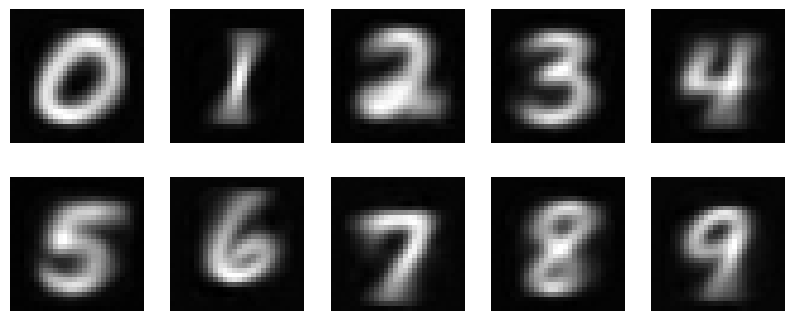

In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

inputs = torch.eye(10)
pred = model(inputs)

fig, axes = plt.subplots(2, 5, figsize=(10, 4))

for i in range(10):
    axes[i//5, i%5].imshow(pred[i, 0].detach().numpy(), cmap="gray")
    axes[i//5, i%5].axis("off")

plt.show()

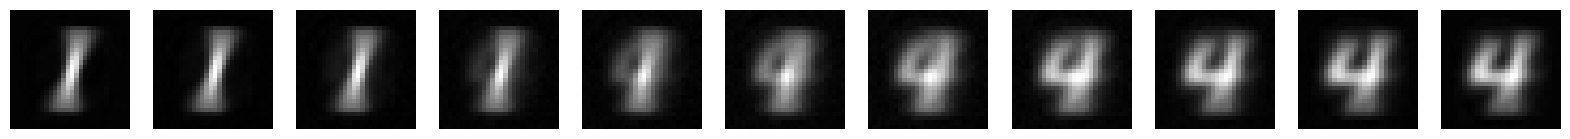

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

morph_start = 1
morph_end = 4

start_oh = torch.eye(10)[morph_start]
end_oh = torch.eye(10)[morph_end]

morphing = [(1-i/10)*start_oh + (i/10)*end_oh for i in range(11)]
morphing = torch.stack(morphing)

pred = model(morphing)

fig, axes = plt.subplots(1, 11, figsize=(20, 4))

for i in range(11):
    axes[i].imshow(pred[i, 0].detach().numpy(), cmap="gray")
    axes[i].axis("off")